In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

torch.__version__

'2.6.0+cpu'

## **PyTorch Workflow**

### **Data (preparing and loading)**

Data can be almost everything in machine learning. For example:
* Exel spreadsheet
* Images of any kind
* Videos
* Signals
* DNA
* Text
* ...

Machine learning is a game of two parts:
* Get data into a numerical representation
* Build a model to learn patterns in that numerical representation

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create a tensor and and an array
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

print(f"Tensor X (first ten values):\n {X[:10]}")
print(f"\nArray y (first ten values):\n {y[:10]}")

Tensor X (first ten values):
 tensor([[0.0000],
        [0.0200],
        [0.0400],
        [0.0600],
        [0.0800],
        [0.1000],
        [0.1200],
        [0.1400],
        [0.1600],
        [0.1800]])

Array y (first ten values):
 tensor([[0.3000],
        [0.3140],
        [0.3280],
        [0.3420],
        [0.3560],
        [0.3700],
        [0.3840],
        [0.3980],
        [0.4120],
        [0.4260]])


In [3]:
print(f"Tensor X length: {len(X)}")
print(f"Array y length: {len(y)}")

Tensor X length: 50
Array y length: 50


In [4]:
# Splitting the data into training and test sets
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
# Or you can split with the scikit-learn library
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    """Plots training data, test data and compares predictions"""
    plt.figure(figsize=(6,4))
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predictions is they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    #Show the legend
    plt.legend(prop={"size":14})

    # Show the plot
    plt.show()

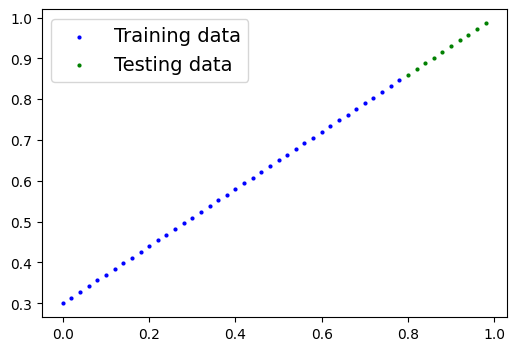

In [6]:
plot_predictions()

### **Build model**

In [7]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch inherits from nn.Module
    # Constructor
    def __init__(self): 
        super().__init__()
        
        # Initialize model parameters
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
        return self.weight * x + self.bias # this is the linear regression formula

**PyTorch model building essentials**
* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should our model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this is where the optimizers in PyTorch live, they will help with gradient descent
* def forward() - all nn.Module subclasses require you to overwrite forward(), this method define what happens in the forward computation

In [8]:
# Create a random seed (for the reproducibility of the example, in reality we don't need to use a random seed)
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List of named parameters
model_0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [10]:
X_test, y_test

(tensor([[0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

In [11]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [12]:
# Making prediction using torch.inference_mode()
with torch.inference_mode(): 
    # The with statement ensures that everything inside its block executes within a specific context
    # In this case the contex is: torch.inference_mode(), when the block ends Python exits the content, 
    # handling any necessary cleanup
    y_preds = model_0(X_test)

y_preds # If NotImplementedError show up: check the model class's indetation

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [13]:
# You can also do something similar with torch.no_grad(), however, torch.inference_mode() is preferred, so use that
"""
    with torch.no_grad():
        y_preds = model_0(X_test)
"""

'\n    with torch.no_grad():\n        y_preds = model_0(X_test)\n'

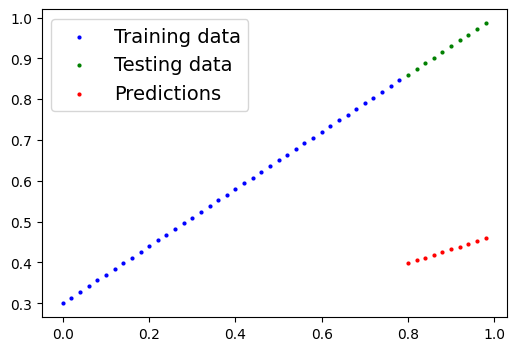

In [14]:
plot_predictions(predictions=y_preds)

### **Train model**

In [15]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # Model's parameters
                            lr=0.01)                     # Learning rate (defualt (for SDG) is 0.1)

In [16]:
torch.manual_seed(42)

# Building a training loop (and testing loop) in PyTorch
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0.Pass the data through the model for a number of epochs
for epoch in range(epochs):
    # Set the model to training mode
    model_0.train() # Train mode in PyTorch sets all parameters that require gradients remain differentiable
                    # This is done because some PyTorch layers and functions behave differently depending on 
                    # whether you are in train or eval mode (this is the default state of a model)

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)

    # 2. Calculate the loss (how different are the model's predictions to the true values)
    loss = loss_fn(y_pred, y_train) # Order: input, target

    # 3. Zero the gradients of the optimizer (they accumulate by default)
    optimizer.zero_grad()

    # 4. Permorm backpropagation on the loss
    loss.backward()

    # 5. Step the optimizer (perform gradient descent)
    optimizer.step() # By default how the optimizer changes will accumulate through the loop, so we have to zero 
                     # them above in step 3 for the next iteration of the loop

    ### Testing
    model_0.eval() # Turn off different settings in the model not needed for evalutation/testing (dropout/batch norm layers)
    with torch.inference_mode(): # Turn off gradient tracking & couple more things behind the scenes
        # 1. Do the forward pass
        test_pred = model_0(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    
    # Print out what's happening
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
        # Print out model state_dict()
        print(f"Model parameters: {model_0.state_dict()}")

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Model parameters: OrderedDict([('weight', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Model parameters: OrderedDict([('weight', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Model parameters: OrderedDict([('weight', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Model parameters: OrderedDict([('weight', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Model parameters: OrderedDict([('weight', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Model parameters: OrderedDict([('weight', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.0381893292069435

In [17]:
weight, bias

(0.7, 0.3)

In [18]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)

y_preds_new

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

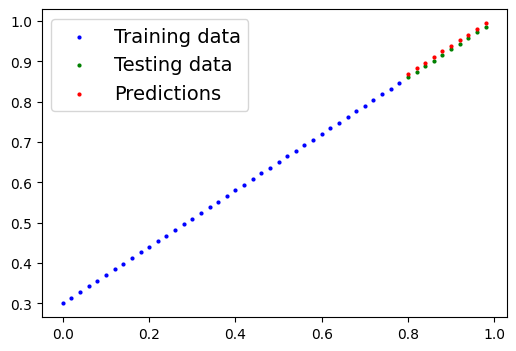

In [19]:
plot_predictions(predictions=y_preds_new)

In [20]:
epoch_count, loss_values, test_loss_values

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190],
 [tensor(0.3129, grad_fn=<MeanBackward0>),
  tensor(0.1977, grad_fn=<MeanBackward0>),
  tensor(0.0891, grad_fn=<MeanBackward0>),
  tensor(0.0531, grad_fn=<MeanBackward0>),
  tensor(0.0454, grad_fn=<MeanBackward0>),
  tensor(0.0417, grad_fn=<MeanBackward0>),
  tensor(0.0382, grad_fn=<MeanBackward0>),
  tensor(0.0348, grad_fn=<MeanBackward0>),
  tensor(0.0313, grad_fn=<MeanBackward0>),
  tensor(0.0279, grad_fn=<MeanBackward0>),
  tensor(0.0245, grad_fn=<MeanBackward0>),
  tensor(0.0210, grad_fn=<MeanBackward0>),
  tensor(0.0176, grad_fn=<MeanBackward0>),
  tensor(0.0142, grad_fn=<MeanBackward0>),
  tensor(0.0107, grad_fn=<MeanBackward0>),
  tensor(0.0073, grad_fn=<MeanBackward0>),
  tensor(0.0039, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>),
  tensor(0.0089, grad_fn=<MeanBackward0>)],
 [tensor(

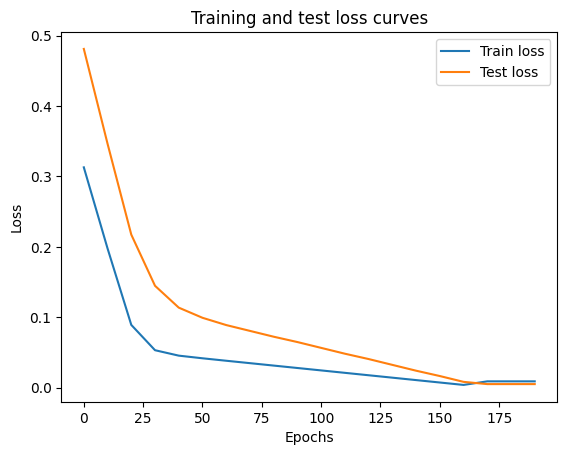

In [21]:
# Plot loss curves (MatPlotLib works with NumPy!)
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### **Saving a model in PyTorch**

There are three main methods you should about for saving and loading model in PyTorch:
1. `torch.save()` - allows you save a PyTorch object in Python's pickle format (a type of object)
2. `torch.load()` - allows you load a saved PyTorch object
3. `torch.nn.Module.load_state_dict()` - this allows to load a model's saved state dictionary

Documentation: https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [22]:
model_0.state_dict()

OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [23]:
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'fused': None,
   'params': [0, 1]}]}

In [24]:
# Saving the PyTorch model

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True) # Create a new directory inside the project's folder

# 2. Create model save path
MODEL_NAME = "01_PyTorch_Workflow_model_0.pth" # Python objects have .pth or .pt extension for PyTorch
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")

# 3. Save the model state dict
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)
print(f"Model saved")

Saving model to: models\01_PyTorch_Workflow_model_0.pth
Model saved


In [25]:
#!dir models

### **Loading a PyTorch model**

Since we saved our model's `state_dict()` rather the entire model, we'll create a new instance of our model class and load the saved `state_dict()` into that.

In [26]:
# To load in a saved state_dict() we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

# Load the saved state_dict of model_0 (this will update the new instance with update parameters)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [27]:
print(f"model_0 state_dict(): {model_0.state_dict()}")
print(f"loaded_model_0 state dict(): {loaded_model_0.state_dict()}")

model_0 state_dict(): OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])
loaded_model_0 state dict(): OrderedDict([('weight', tensor([0.6990])), ('bias', tensor([0.3093]))])


In [28]:
# Make some prediction with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [29]:
# Compare loaded model preds with original model preds
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

### **Putting all together**

In [30]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [31]:
#!nvidia-smi

#### **6.1 Creating data**

In [32]:
# Create some data using the linear regression formula y = xw + b
weight = 0.7
bias = 0.3

# Create range value
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # Without unsqueeze, errors will pop up
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [33]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

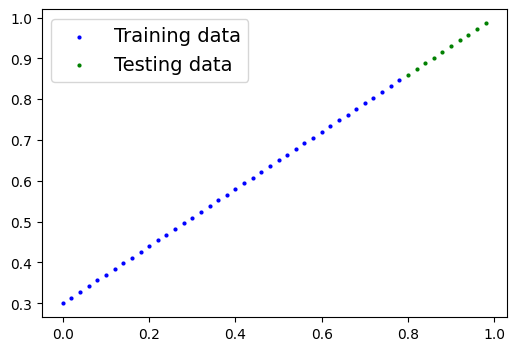

In [34]:
plot_predictions(X_train, y_train, X_test, y_test)

#### **6.2 Building a PyTorch linear model**

In [35]:
# Create a lineare model by subclassing nn.Module
class LinearRegressionModelv2(nn.Module):
    def __init__(self):
        super().__init__()

        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,  # Number (dimension) of the input
                                      out_features=1) # Number (dimension) of the output

    def forward(self, x: torch.Tensor) -> torch.Tensor: # x: torch.Tensor (type input), -> torch.Tensor (type output)
        return self.linear_layer(x)
    
# Set the manual seed
torch.manual_seed(42)
model_1 = LinearRegressionModelv2()
model_1, model_1.state_dict()

(LinearRegressionModelv2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [36]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [37]:
# Set the module to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cpu')

#### **6.3 Training**

In [38]:
# Setup loss function
loss_fn = nn.L1Loss()

# Setup optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [39]:
### Training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnoistic code for data)
X_train.to(device)
y_train.to(device)
X_test.to(device)
y_test.to(device)

for epoch in range(epochs):
    model_1.train()
    y_pred = model_1(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        test_pred = model_1(X_test)
        test_loss = loss_fn(test_pred, y_test)

        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
            print(f"Model parameters: {model_1.state_dict()}")
            

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Model parameters: OrderedDict([('linear_layer.weight', tensor([[0.7606]])), ('linear_layer.bias', tensor([0.8200]))])
Epoch: 10 | Loss: 0.4399680495262146 | Test loss: 0.4392663538455963
Model parameters: OrderedDict([('linear_layer.weight', tensor([[0.7216]])), ('linear_layer.bias', tensor([0.7200]))])
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Model parameters: OrderedDict([('linear_layer.weight', tensor([[0.6826]])), ('linear_layer.bias', tensor([0.6200]))])
Epoch: 30 | Loss: 0.20954827964305878 | Test loss: 0.16984674334526062
Model parameters: OrderedDict([('linear_layer.weight', tensor([[0.6436]])), ('linear_layer.bias', tensor([0.5200]))])
Epoch: 40 | Loss: 0.09433844685554504 | Test loss: 0.03513689711689949
Model parameters: OrderedDict([('linear_layer.weight', tensor([[0.6046]])), ('linear_layer.bias', tensor([0.4200]))])
Epoch: 50 | Loss: 0.023886386305093765 | Test loss: 0.0478490

In [40]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]])),
             ('linear_layer.bias', tensor([0.3025]))])

In [41]:
weight, bias

(0.7, 0.3)

#### **6.4 Making and evaluating predictions**

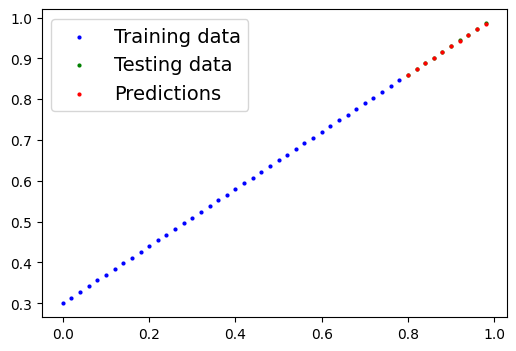

In [42]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds_model_1 = model_1(X_test)

# Check out our model predictions visually (remember: MatPlotLib work only in cpu mode)
plot_predictions(predictions=y_preds_model_1.cpu())

#### **6.5 Saving and loading a trained model**

In [43]:
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_PyTorch_Workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")

# 3. Save the model state dict
torch.save(obj=model_1.state_dict(), f=MODEL_SAVE_PATH)
print(f"Model saved")


Saving model to: models\01_PyTorch_Workflow_model_1.pth
Model saved


In [44]:
# Load a PyTorch model

# Create a new istance of linear regression model V2
loaded_model_1 = LinearRegressionModelv2()

# Load the saved model_1 state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to the device
loaded_model_1.to(device)
next(loaded_model_1.parameters()).device

device(type='cpu')

In [45]:
print(f"model_1 state_dict(): {model_1.state_dict()}")
print(f"loaded_model_1 state_dict(): {loaded_model_1.state_dict()}")

model_1 state_dict(): OrderedDict([('linear_layer.weight', tensor([[0.6968]])), ('linear_layer.bias', tensor([0.3025]))])
loaded_model_1 state_dict(): OrderedDict([('linear_layer.weight', tensor([[0.6968]])), ('linear_layer.bias', tensor([0.3025]))])


In [46]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)

y_preds_model_1 == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## **Exercises**

#### 1. Create a straight line dataset using the linear regression formula (`weight * X + bias`)
* Set `weight=0.3` and `bias=0.9` there should be at least 100 datapoints total
* Split the data into 80% training, 20% testing
* Plot the training and testing data so it becomes visual

In [47]:
weight = 0.3
bias = 0.9
start = 0
end = 1
step = 0.01

X = torch.arange(start, end, step).unsqueeze(dim=1) # Because PyTorch models want tensor in input (not array 1-dim)
y = weight * X + bias

split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [48]:
def plot_predictionsExercise(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    plt.figure(figsize=(8,6))
    
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predictions is they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
    
    #Show the legend
    plt.legend(prop={"size":14})

    plt.show()

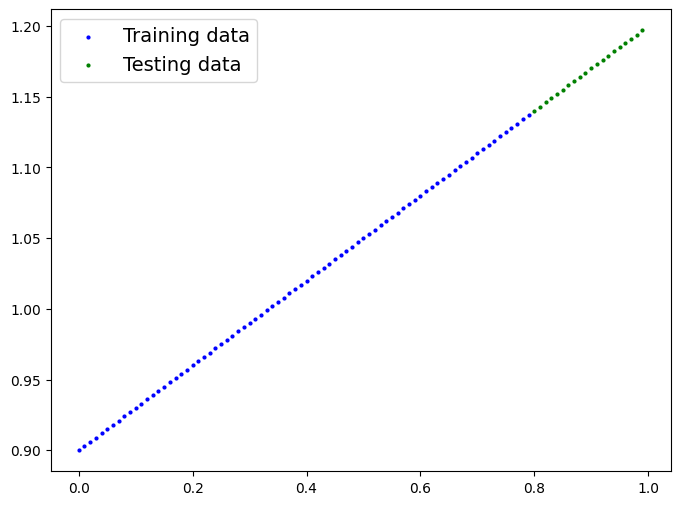

In [49]:
plot_predictionsExercise(X_train, y_train, X_test, y_test)

#### 2. Build a PyTorch model by subclassing `nn.Module`
* Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`
* Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1
* Once you've constructed the model, make an instance of it and check its `state_dict()`
* Note: If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can

In [50]:
class LinearRegressionModelExercise(nn.Module):
    def __init__(self):
        super().__init__()

        # nn.Linear has requires_grad=True by defualt
        self.linear_layer = nn.Linear(in_features=1, out_features=1) 

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
torch.manual_seed(37)
model_exercise = LinearRegressionModelExercise()
model_exercise.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.5823]])),
             ('linear_layer.bias', tensor([0.2837]))])

#### 3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively
* Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2
* Write a training loop to perform the appropriate training steps for 300 epochs
* The training loop should test the model on the test dataset every 20 epochs

In [51]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_exercise.parameters(), lr=0.01)

### Training loop
torch.manual_seed(37)

epochs = 300

for epoch in range(epochs):
    model_exercise.train()
    y_pred = model_exercise(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        ### Testing
        model_exercise.eval()
        with torch.inference_mode():
            test_pred = model_exercise(X_test)
            test_loss = loss_fn(test_pred, y_test)
            print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
            print(f"Model parameters: {model_exercise.state_dict()}\n")

Epoch: 0 | Loss: 0.5047718286514282 | Test loss: 0.3501056730747223
Model parameters: OrderedDict([('linear_layer.weight', tensor([[0.5862]])), ('linear_layer.bias', tensor([0.2937]))])

Epoch: 20 | Loss: 0.2735670208930969 | Test loss: 0.07940086722373962
Model parameters: OrderedDict([('linear_layer.weight', tensor([[0.6652]])), ('linear_layer.bias', tensor([0.4937]))])

Epoch: 40 | Loss: 0.10264377295970917 | Test loss: 0.13547955453395844
Model parameters: OrderedDict([('linear_layer.weight', tensor([[0.7198]])), ('linear_layer.bias', tensor([0.6597]))])

Epoch: 60 | Loss: 0.08341924846172333 | Test loss: 0.17673270404338837
Model parameters: OrderedDict([('linear_layer.weight', tensor([[0.7047]])), ('linear_layer.bias', tensor([0.7145]))])

Epoch: 80 | Loss: 0.07591880112886429 | Test loss: 0.17359714210033417
Model parameters: OrderedDict([('linear_layer.weight', tensor([[0.6747]])), ('linear_layer.bias', tensor([0.7382]))])

Epoch: 100 | Loss: 0.06903854012489319 | Test loss: 0.

#### 4. Make predictions with the trained model on the test data.
* Visualize these predictions against the original training and testing data (note: you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

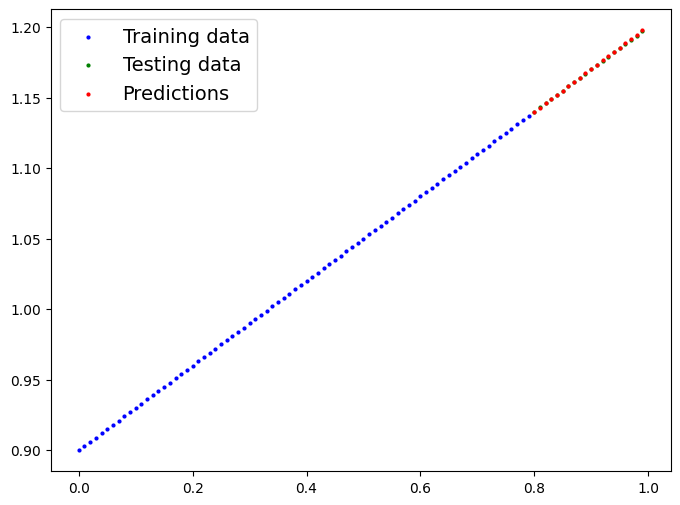

In [54]:
model_exercise.eval()
with torch.inference_mode():
    y_preds_model_exercise = model_exercise(X_test)

plot_predictionsExercise(predictions=y_preds_model_exercise)

#### 5. Save your trained model's `state_dict()` to file.
* Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
* Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [53]:
# Save the model state dict
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "01_PyTorch_Workflow_model_exercise.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_exercise.state_dict(), f=MODEL_SAVE_PATH)
print(f"Model saved")

# Create a new istance of the exercise's model
loaded_model_exercise = LinearRegressionModelExercise()

# Load the saved model_exercise state dict
loaded_model_exercise.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Evaluate loaded model
loaded_model_exercise.eval()
with torch.inference_mode():
    loaded_model_exercise_preds = loaded_model_exercise(X_test)

y_preds_model_exercise == loaded_model_exercise_preds

Saving model to: models\01_PyTorch_Workflow_model_exercise.pth
Model saved


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])